In [34]:
import json, geojson, os, sys
import numpy as np
from scipy import stats
from shapely import geometry, ops
import datetime as dt

import descarteslabs as dl
import requests

In [5]:
import geopandas as gpd
gpd.options.use_pygeos=True

In [8]:
root = os.path.abspath(os.path.join(os.getcwd(),'..','..','..'))

In [10]:
gdf = gpd.read_file(os.path.join(root,'data','SPV_wdpa.gpkg'))

In [13]:
import descarteslabs.workflows as wf

In [14]:
ic = wf.ImageCollection.from_id("oxfordeo:clc_300m_landcover", 
                                                        start_datetime='2018-12-30', 
                                                        end_datetime='2019-01-03')

In [28]:
ft = gdf.iloc[0:3].to_dict('records')[2]

In [47]:
rc = dl.Raster()

In [49]:
tiles = rc.dltiles_from_shape(10, 20, 0, ft['geometry'])['features']

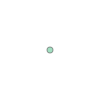

In [55]:
ft['geometry'].representative_point()

In [56]:
pt = ft['geometry'].representative_point()

In [57]:
tile = rc.dltile_from_latlon(pt.y, pt.x, 100, 1, 0)

In [58]:
sc = dl.scenes.search(tile['geometry'], products=['oxfordeo:clc_300m_landcover'], start_datetime='2018-12-30', end_datetime='2019-01-03')

RetryError: HTTPSConnectionPool(host='platform.descarteslabs.com', port=443): Max retries exceeded with url: /metadata/v1/search (Caused by ResponseError('too many 429 error responses',))

In [44]:
class_map = ic.compute(geoctx=wf.GeoContext(geometry=ft['geometry'],resolution=0.0002778,crs='EPSG:4326'))


Job ID: eaf6be2b775cae597f17cf5b3f35b46c512e32c4c0630df2
[######] | Steps: 2/2 | Stage: SUCCEEDED                                      

In [45]:
class_map

ImageCollectionResult of length 1:
  * ndarray: MaskedArray<shape=(1, 1, 7, 12), dtype=float64>
  * properties: 1 items
  * bandinfo: 'discrete_classification'
  * geocontext: 'geometry', 'resolution', 'crs', 'bounds', ...

In [46]:
class_map.ndarray

masked_array(
  data=[[[[--, --, --, --, --, --, --, --, --, --, --, --],
          [--, --, --, --, --, --, --, --, --, --, --, --],
          [--, --, --, --, --, --, --, --, --, --, --, --],
          [--, --, --, --, --, --, --, --, --, --, --, --],
          [--, --, --, --, --, --, --, --, --, --, --, --],
          [--, --, --, --, --, --, --, --, --, --, --, --],
          [--, --, --, --, --, --, --, --, --, --, --, --]]]],
  mask=[[[[ True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True],
          [ True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True],
          [ True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True],
          [ True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True],
          [ True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True],
          [ True,  True,  Tr

In [30]:
def cloud_worker(ft, storage_key, storage_flag):
    
    import json, geojson, os, sys
    import numpy as np
    from scipy import stats
    from shapely import geometry
    import datetime as dt

    import descarteslabs as dl
    import descarteslabs.workflows as wf
    
    raster_client = dl.Raster()
    metadata_client = dl.Metadata()
    storage_client = dl.Storage()


    corine_countries = ['AL', 'AT', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'XK', 'LV', 'LI', 'LT', 'LU', 'MK', 'MT', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SK', 'SI', 'ES', 'SE', 'CH', 'TR', 'GB']

    if storage_flag:
        ft = json.loads(storage_client.get(storage_key,storage_type='data'))
    else:
        ft = json.loads(ft)
    
    if ft['properties']['iso-3166-1']=='US':
        do_region='US'
    elif ft['properties']['iso-3166-1'] in corine_countries:
        do_region='CORINE'
    else:
        do_region='REMAINDER'

    print (do_region, ft)


    image_collections = {}


    if do_region=='US':

        key = 'land_cover_CDL_'

        start_dates = [str(yr)+'-12-30' for yr in range(2005,2018)]

        for date in start_dates:
            sdate = dt.datetime.strptime(date,'%Y-%m-%d')
            edate = sdate + dt.timedelta(days=3)

            image_collections[edate.isoformat()[0:4]] = wf.ImageCollection.from_id("usda:cdl:v1", 
                                                        start_datetime=sdate.isoformat()[0:10], 
                                                        end_datetime=edate.isoformat()[0:10])

    elif do_region=='CORINE':

        key = 'land_cover_CORINE_'

        start_dates = ['2006-12-30', '2012-12-30', '2018-12-30']

        for date in start_dates:
            sdate = dt.datetime.strptime(date,'%Y-%m-%d')
            edate = sdate + dt.timedelta(days=3)

            image_collections[sdate.isoformat()[0:4]] = wf.ImageCollection.from_id("oxford-university:corine-land-cover", 
                                                        start_datetime=sdate.isoformat()[0:10], 
                                                        end_datetime=edate.isoformat()[0:10])


    else:

        key = 'land_cover_MODIS_'

        start_dates = start_dates = [str(yr)+'-12-30' for yr in range(2005,2013)]

        for date in start_dates:
            sdate = dt.datetime.strptime(date,'%Y-%m-%d')
            edate = sdate + dt.timedelta(days=3)

            image_collections[edate.isoformat()[0:4]] = {'product':"modis:mcd12q1:051",
                                                         'bands':['Land_Cover_Type_1'],
                                                        'sdate':sdate.isoformat()[0:10], 
                                                        'edate':edate.isoformat()[0:10]}

        start_dates = start_dates = [str(yr)+'-12-30' for yr in range(2013,2018)]

        for date in start_dates:
            sdate = dt.datetime.strptime(date,'%Y-%m-%d')
            edate = sdate + dt.timedelta(days=3)

            image_collections[edate.isoformat()[0:4]] = {'product':"oxford-university:modis-land-cover", 
                                                         'bands':['IGBP_class'],
                                                        'sdate':sdate.isoformat()[0:10], 
                                                        'edate':edate.isoformat()[0:10]}

    print (key, image_collections.keys())
        
    if key=='land_cover_MODIS_':
        pt = geometry.shape(ft['geometry']).representative_point()
        tile = raster_client.dltile_from_latlon(pt.y, pt.x, 500, 1, 0)


    if do_region in ['US','CN','REMAINDER']:
        yr_range = range(2006, 2019)
    elif do_region=='CORINE':
        yr_range = [2006, 2012, 2018]

    for yr in yr_range:
        
        try:

            if key=='land_cover_MODIS_':

                scenes = metadata_client.search(image_collections[str(yr)]['product'], 
                                                geom=tile['geometry'], 
                                                start_datetime=image_collections[str(yr)]['sdate'],  
                                                end_datetime=image_collections[str(yr)]['edate'])['features']

                arr, meta = raster_client.ndarray(scenes[0].id, bands=image_collections[str(yr)]['bands'], scales=[[0,255]], ot='Byte', dltile=tile['properties']['key'])

                class_mode = int(stats.mode(arr.flatten()).mode[0])

                if (yr<2014) and (class_mode==0):
                    class_mode=17

            else:
                class_map = image_collections[str(yr)].compute(geoctx=wf.GeoContext(geometry=ft['geometry'],
                                                            resolution=10.,
                                                            crs='EPSG:3857'))
                class_mode = int(stats.mode(class_map.ndarray.data[class_map.ndarray.mask==0]).mode[0])

                #print (yr,'class mode',class_mode)



            print (yr, class_mode)

            ft['properties'][key+str(yr)] = class_mode
        except Exception as e:
            print ('Error!', e)
            ft['properties'][key+str(yr)] = 'null'


    return ft





In [3]:
fc = json.load(open('./ABCD_simplified.geojson','r'))

In [27]:
for ii_f, ft in enumerate(fc['features']):
    ft['id']=ii_f

In [4]:
tasks = dl.Tasks()

In [34]:
fn = tasks.create_function(
            cloud_worker,
            image='us.gcr.io/dl-ci-cd/images/tasks/public/py3.7:v1.1.1',
            name='ft_landcover_v3',
            requirements=[],
            maximum_concurrency=500,
            memory='3.5Gi',
            retry_count=0,
            task_timeout=10800,
            )

In [9]:
fn(fc['features'][0])

Task
	Status: Pending

In [11]:
corine_countries = ['AL', 'AT', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'XK', 'LV', 'LI', 'LT', 'LU', 'MK', 'MT', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SK', 'SI', 'ES', 'SE', 'CH', 'TR', 'GB']


In [16]:
CORINE_fts = [ft for ft in fc['features'] if ft['properties']['iso-3166-1'] in corine_countries]

In [17]:
US_fts = [ft for ft in fc['features'] if ft['properties']['iso-3166-1'] in ['US']]

In [18]:
REM_fts = [ft for ft in fc['features'] if ft['properties']['iso-3166-1'] not in corine_countries + ['US']]

In [24]:
fn(CORINE_fts[0])

Task
	Status: Pending

In [25]:
fn(US_fts[0])

Task
	Status: Pending

In [26]:
fn(REM_fts[0])

Task
	Status: Pending

In [29]:
storage_client = dl.Storage()

In [33]:
tasks_list = []
for ft in fc['features'][100:]:
    print (ft['id'])
    try:
        fn(json.dumps(ft),None, None)
    except:
        print ('writing to storage...', ft['id'])
        key='land_cover_map_'+str(ft['id'])+'.ft'
        storage_client.set(key, json.dumps(ft))
        fn(None,key, 1)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


In [56]:
group = tasks.get_group('562ab075')

In [58]:
tasks.rerun_failed_tasks(group.id)

[{
   'arguments': ['{"type": "Feature", "geometry": {"type": "...", "area": 20889.85287557591}, "id": 68201}', None, None],
   'attributes': {},
   'executable_uri': None,
   'function_python_version': None,
   'id': '1140628514754222',
   'labels': None,
   'parameters': {},
   'retry_count': 0,
   'webhook': None
 },
 {
   'arguments': ['{"type": "Feature", "geometry": {"type": "... "CZ", "iso-3166-2": "CZ-US"}, "id": 54793}', None, None],
   'attributes': {},
   'executable_uri': None,
   'function_python_version': None,
   'id': '1140614758957259',
   'labels': None,
   'parameters': {},
   'retry_count': 0,
   'webhook': None
 },
 {
   'arguments': ['{"type": "Feature", "geometry": {"type": "... "ES", "iso-3166-2": "ES-SA"}, "id": 55316}', None, None],
   'attributes': {},
   'executable_uri': None,
   'function_python_version': None,
   'id': '1140621184972178',
   'labels': None,
   'parameters': {},
   'retry_count': 0,
   'webhook': None
 },
 {
   'arguments': ['{"type": "Fea

In [42]:
timeouts = tasks.get_task_results(group.id, limit=1000,status='FAILURE', include=['arguments'])

In [55]:
for r in timeouts['results']:
    args = json.loads(r['arguments'])['args']
    fn (*args)

### Get features and visualise

In [85]:
tasks = dl.Tasks()

In [86]:
results = tasks.get_task_results('35848d1c', include=['result_url'], limit=1000)['results']

In [87]:
q = tasks.get_task_results('562ab075', include=['result_url'], limit=1000)
token = q['continuation_token']
results += q['results']

counter = 0
while token:
    counter+=1
    q = tasks.get_task_results('562ab075', include=['result_url'], limit=1000, continuation_token=token)
    token = q['continuation_token']
    results += q['results']
    print (counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


In [99]:
def mp_rejoin(ii,urls):
    fts = []
    for ii_u, url in enumerate(urls):
        if ii_u %1000==0:
            print (f'Logging: {ii}, {ii_u}')
        try:
            r = requests.get(url)
            fts.append(json.loads(r.text))
        except Exception as e:
            print ('ERROR!',e)
            
    return fts

In [88]:
pool_size=4
chunk = len(results)//pool_size +1

In [92]:
all_urls = [r['result_url'] for r in results]

In [93]:
urls_reshape = [all_urls[ii*chunk:(ii+1)*chunk] for ii in range(pool_size)]

In [100]:
len(urls_reshape)

4

In [97]:
import multiprocessing as mp

In [98]:
pool = mp.Pool(pool_size)

0
0
0
0
1000
1000
1000
1000
2000
2000
3000
2000
3000
2000
4000
4000
3000
3000
5000
5000
6000
6000
4000
4000
7000
7000
5000
5000
8000
8000
9000
9000
6000
6000
10000
10000
7000
7000
11000
11000
12000
8000
12000
8000
13000
13000
9000
ERROR! Expecting value: line 1 column 1 (char 0)
9000
14000
14000
10000
15000
10000
15000
16000
11000
11000
16000
17000
12000
12000
17000
13000
13000
14000
14000
15000
15000
16000
16000
17000
17000


In [101]:
all_fts = pool.starmap(mp_rejoin, list(zip(range(pool_size), urls_reshape)))

In [102]:
new_fts = []
for bunch in all_fts:
    print (len(bunch))
    new_fts +=bunch

17202
17201
17202
17198


In [105]:
json.dump(geojson.FeatureCollection(new_fts), open('./ABCD_landcover.geojson','w'))

### Visualise

In [2]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
from datetime import timedelta

In [3]:
colors_dict = {
    'forest':'#2f9149',
    'grasslands':'#b6eb7f',
    'wetlands':'#7fe7eb',
    'cropland':'#ff9500',
    'developed':'#d000ff',
    'other':'#bdbdbd',
}

In [4]:
colors_base = {
    'forestshrub':'#2f9149',
    'grassy':'#b6eb7f',
    'wetlands':'#7fe7eb',
    'cropland':'#ff9500',
    'human':'#d000ff',
    'other':'#bdbdbd',
    np.nan:'#bdbdbd'
}

In [5]:
corine_countries = ['AL', 'AT', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'XK', 'LV', 'LI', 'LT', 'LU', 'MK', 'MT', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SK', 'SI', 'ES', 'SE', 'CH', 'TR', 'GB']

In [6]:
landcover_fts = json.load(open('./ABCD_landcover.geojson','r'))['features']

In [191]:
df = pd.DataFrame.from_records([ft['properties'] for ft in landcover_fts])

In [192]:
#df = df[(df['install_date']!='<2016-06') & (df['install_date']!='')]

In [193]:
df['install_date'] = df['install_date'].str.replace('<2016-06','')

In [194]:
df['install_date'] = df['install_date'].str.replace(',','')

In [195]:
df['install_date'] = df['install_date'].str[0:10]

In [196]:
df['dt_obj'] = pd.to_datetime(df['install_date'])

In [6]:
import pickle

In [10]:
labels = {}
labels['CORINE'] = pickle.load(open('./../../../data/class_labels_CORINE.pkl','rb'))
labels['MODIS'] = pickle.load(open('./../../../data/class_labels_MODIS.pkl','rb'))
labels['CDL'] = pickle.load(open('./../../../data/class_labels_cdl.pkl','rb'))

In [11]:
labels['CDL']

{0: 'Undefined',
 1: 'Corn',
 2: 'Cotton',
 3: 'Rice',
 4: 'Sorghum',
 5: 'Soybeans',
 6: 'Sunflower',
 7: '',
 8: '',
 9: '',
 10: 'Peanuts',
 11: 'Tobacco',
 12: 'Sweet Corn',
 13: 'Pop or Orn Corn',
 14: 'Mint',
 15: '',
 16: '',
 17: '',
 18: '',
 19: '',
 20: '',
 21: 'Barley',
 22: 'Durum Wheat',
 23: 'Spring Wheat',
 24: 'Winter Wheat',
 25: 'Other Small Grains',
 26: 'Dbl Crop WinWht/Soybeans',
 27: 'Rye',
 28: 'Oats',
 29: 'Millet',
 30: 'Speltz',
 31: 'Canola',
 32: 'Flaxseed',
 33: 'Safflower',
 34: 'Rape Seed',
 35: 'Mustard',
 36: 'Alfalfa',
 37: 'Other Hay/Non Alfalfa',
 38: 'Camelina',
 39: 'Buckwheat',
 40: '',
 41: 'Sugarbeets',
 42: 'Dry Beans',
 43: 'Potatoes',
 44: 'Other Crops',
 45: 'Sugarcane',
 46: 'Sweet Potatoes',
 47: 'Misc Vegs & Fruits',
 48: 'Watermelons',
 49: 'Onions',
 50: 'Cucumbers',
 51: 'Chick Peas',
 52: 'Lentils',
 53: 'Peas',
 54: 'Tomatoes',
 55: 'Caneberries',
 56: 'Hops',
 57: 'Herbs',
 58: 'Clover/Wildflowers',
 59: 'Sod/Grass Seed',
 60: 'Sw

In [12]:
labels_agg = {}

In [13]:
labels_agg['CORINE'] = {
    'forestshrub':[23,24,25,29],
    'wetlands':[35,36,37,38],
    'human':[1,2,3,4,5,6,7,8,9,10,11],
    'cropland':[12,13,14,15,16,17,18,19,20,21,22],
    'grassy':[26,27,28,],
    'other':[30,31,32,33,34,39,40,41,42,43,44,45,46,47],
}

In [14]:
labels_agg['MODIS'] = {    
    'forestshrub':[1,2,3,4,5,6,7,8],
    'wetlands':[11],
    'human':[13],
    'cropland':[12,14],
    'grassy':[9,10],
    'other':[15,16,17],
}

In [15]:
labels_agg['CDL'] = {    
    'forestshrub':[63,64, 141, 142, 143, 152],
    'wetlands':[87, 190, 195],
    'human':[82, 121, 122, 123, 124],
    'cropland':[], # else
    'grassy':[59,60,61,62, 176],
    'other':[0, 65, 81, 83, 88, 111, 112, 131], #''
}

In [16]:
existing_labels = [el for kk,vv in labels_agg['CDL'].items() for el in vv]

In [17]:
for kk, vv in labels['CDL'].items():
    if kk not in existing_labels:
        if vv=='':
            labels_agg['CDL']['other'].append(kk)
        else:
            labels_agg['CDL']['cropland'].append(kk)

In [22]:
labels_agg

{'CORINE': {'forestshrub': [23, 24, 25, 29],
  'wetlands': [35, 36, 37, 38],
  'human': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  'cropland': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
  'grassy': [26, 27, 28],
  'other': [30, 31, 32, 33, 34, 39, 40, 41, 42, 43, 44, 45, 46, 47]},
 'MODIS': {'forestshrub': [1, 2, 3, 4, 5, 6, 7, 8],
  'wetlands': [11],
  'human': [13],
  'cropland': [12, 14],
  'grassy': [9, 10],
  'other': [15, 16, 17]},
 'CDL': {'forestshrub': [63, 64, 141, 142, 143, 152],
  'wetlands': [87, 190, 195],
  'human': [82, 121, 122, 123, 124],
  'cropland': [1,
   2,
   3,
   4,
   5,
   6,
   10,
   11,
   12,
   13,
   14,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   74,
   75,
   76,
   77,
   92,
   204,
   2

In [25]:
labels

{'CORINE': {1: {'code': '111', 'description': 'Continuous urban fabric'},
  2: {'code': '112', 'description': 'Discontinuous urban fabric'},
  3: {'code': '121', 'description': 'Industrial or commercial units'},
  4: {'code': '122',
   'description': 'Road and rail networks and associated land'},
  5: {'code': '123', 'description': 'Port areas'},
  6: {'code': '124', 'description': 'Airports'},
  7: {'code': '131', 'description': 'Mineral extraction sites'},
  8: {'code': '132', 'description': 'Dump sites'},
  9: {'code': '133', 'description': 'Construction sites'},
  10: {'code': '141', 'description': 'Green urban areas'},
  11: {'code': '142', 'description': 'Sport and leisure facilities'},
  12: {'code': '211', 'description': 'Non-irrigated arable land'},
  13: {'code': '212', 'description': 'Permanently irrigated land'},
  14: {'code': '213', 'description': 'Rice fields'},
  15: {'code': '221', 'description': 'Vineyards'},
  16: {'code': '222', 'description': 'Fruit trees and berry

In [26]:
for platform,vv in labels_agg.items():
    for macroclass, indexes in vv.items():
        print (platform, macroclass)
        for ind in indexes:
            print (labels[platform][ind])

CORINE forestshrub
{'code': '311', 'description': 'Broad-leaved forest'}
{'code': '312', 'description': 'Coniferous forest'}
{'code': '313', 'description': 'Mixed forest'}
{'code': '324', 'description': 'Transitional woodland-shrub'}
CORINE wetlands
{'code': '411', 'description': 'Inland marshes'}
{'code': '412', 'description': 'Peat bogs'}
{'code': '421', 'description': 'Salt marshes'}
{'code': '422', 'description': 'Salines'}
CORINE human
{'code': '111', 'description': 'Continuous urban fabric'}
{'code': '112', 'description': 'Discontinuous urban fabric'}
{'code': '121', 'description': 'Industrial or commercial units'}
{'code': '122', 'description': 'Road and rail networks and associated land'}
{'code': '123', 'description': 'Port areas'}
{'code': '124', 'description': 'Airports'}
{'code': '131', 'description': 'Mineral extraction sites'}
{'code': '132', 'description': 'Dump sites'}
{'code': '133', 'description': 'Construction sites'}
{'code': '141', 'description': 'Green urban areas

In [204]:
df_cdl = pd.DataFrame.from_dict(labels_agg['CDL'], orient='index')

In [205]:
df_cdl = df_cdl.unstack().dropna().reset_index().set_index(0).drop(columns=['level_0']).sort_index()

In [206]:
df_cdl.index = df_cdl.index.astype(int)

In [207]:
df_corine = pd.DataFrame.from_dict(labels_agg['CORINE'], orient='index')

In [208]:
df_corine = df_corine.unstack().dropna().reset_index().set_index(0).drop(columns=['level_0']).sort_index()

In [209]:
df_corine.index = df_corine.index.astype(int)

In [210]:
df_modis = pd.DataFrame.from_dict(labels_agg['MODIS'], orient='index')

In [211]:
df_modis = df_modis.unstack().dropna().reset_index().set_index(0).drop(columns=['level_0']).sort_index()

In [212]:
df_modis.index = df_modis.index.astype(int)

In [213]:
df['land_cover_vis'] = ''
df['land_cover_code'] = np.nan

In [214]:
df.loc[df['iso-3166-1']=='US','land_cover_vis'] = df.loc[df['iso-3166-1']=='US','land_cover_CDL_2012'].map(df_cdl.to_dict()['level_1'])

In [215]:
df.loc[df['iso-3166-1'].isin(corine_countries),'land_cover_vis'] = df.loc[df['iso-3166-1'].isin(corine_countries),'land_cover_CORINE_2012'].map(df_corine.to_dict()['level_1'])

In [216]:
df.loc[~df['iso-3166-1'].isin(corine_countries+['US']),'land_cover_vis'] = df.loc[~df['iso-3166-1'].isin(corine_countries+['US']),'land_cover_MODIS_2012'].map(df_modis.to_dict()['level_1'])

### Check 'Other'

In [217]:
df.loc[df['iso-3166-1']=='US','land_cover_code'] = df.loc[df['iso-3166-1']=='US','land_cover_CDL_2012']
df.loc[df['iso-3166-1'].isin(corine_countries),'land_cover_code'] = df.loc[df['iso-3166-1'].isin(corine_countries),'land_cover_CORINE_2012']
df.loc[~df['iso-3166-1'].isin(corine_countries+['US']),'land_cover_code'] = df.loc[~df['iso-3166-1'].isin(corine_countries+['US']),'land_cover_MODIS_2012']

In [223]:
df.loc[~df['iso-3166-1'].isin(corine_countries+['US']) & (df['land_cover_vis']=='other')].groupby('land_cover_code').size()

land_cover_code
15       5
16    1104
17     176
dtype: int64

In [224]:
labels['MODIS']

{1: 'Evergreen Needleleaf Forests: dominated by evergreen conifer trees (canopy >2m). Tree cover >60%.',
 2: 'Evergreen Broadleaf Forests: dominated by evergreen broadleaf and palmate trees (canopy >2m). Tree cover >60%.',
 3: 'Deciduous Needleleaf Forests: dominated by deciduous needleleaf (larch) trees (canopy >2m). Tree cover >60%.',
 4: 'Deciduous Broadleaf Forests: dominated by deciduous broadleaf trees (canopy >2m). Tree cover >60%.',
 5: 'Mixed Forests: dominated by neither deciduous nor evergreen (40-60% of each) tree type (canopy >2m). Tree cover >60%.',
 6: 'Closed Shrublands: dominated by woody perennials (1-2m height) >60% cover.',
 7: 'Open Shrublands: dominated by woody perennials (1-2m height) 10-60% cover.',
 8: 'Woody Savannas: tree cover 30-60% (canopy >2m).',
 9: 'Savannas: tree cover 10-30% (canopy >2m).',
 10: 'Grasslands: dominated by herbaceous annuals (<2m).',
 11: 'Permanent Wetlands: permanently inundated lands with 30-60% water cover and >10% vegetated cover.

In [225]:
df.loc[df['iso-3166-1'].isin(corine_countries) & (df['land_cover_vis']=='other')].groupby('land_cover_code').size()

land_cover_code
30     4
31     4
32    85
40     2
41    10
dtype: int64

In [226]:
labels['CORINE']

{1: {'code': '111', 'description': 'Continuous urban fabric'},
 2: {'code': '112', 'description': 'Discontinuous urban fabric'},
 3: {'code': '121', 'description': 'Industrial or commercial units'},
 4: {'code': '122',
  'description': 'Road and rail networks and associated land'},
 5: {'code': '123', 'description': 'Port areas'},
 6: {'code': '124', 'description': 'Airports'},
 7: {'code': '131', 'description': 'Mineral extraction sites'},
 8: {'code': '132', 'description': 'Dump sites'},
 9: {'code': '133', 'description': 'Construction sites'},
 10: {'code': '141', 'description': 'Green urban areas'},
 11: {'code': '142', 'description': 'Sport and leisure facilities'},
 12: {'code': '211', 'description': 'Non-irrigated arable land'},
 13: {'code': '212', 'description': 'Permanently irrigated land'},
 14: {'code': '213', 'description': 'Rice fields'},
 15: {'code': '221', 'description': 'Vineyards'},
 16: {'code': '222', 'description': 'Fruit trees and berry plantations'},
 17: {'code

In [227]:
df.loc[(df['iso-3166-1']=='US') & (df['land_cover_vis']=='other')].groupby('land_cover_code').size()

land_cover_code
111     12
131    197
dtype: int64

In [228]:
labels['CDL']

{0: 'Undefined',
 1: 'Corn',
 2: 'Cotton',
 3: 'Rice',
 4: 'Sorghum',
 5: 'Soybeans',
 6: 'Sunflower',
 7: '',
 8: '',
 9: '',
 10: 'Peanuts',
 11: 'Tobacco',
 12: 'Sweet Corn',
 13: 'Pop or Orn Corn',
 14: 'Mint',
 15: '',
 16: '',
 17: '',
 18: '',
 19: '',
 20: '',
 21: 'Barley',
 22: 'Durum Wheat',
 23: 'Spring Wheat',
 24: 'Winter Wheat',
 25: 'Other Small Grains',
 26: 'Dbl Crop WinWht/Soybeans',
 27: 'Rye',
 28: 'Oats',
 29: 'Millet',
 30: 'Speltz',
 31: 'Canola',
 32: 'Flaxseed',
 33: 'Safflower',
 34: 'Rape Seed',
 35: 'Mustard',
 36: 'Alfalfa',
 37: 'Other Hay/Non Alfalfa',
 38: 'Camelina',
 39: 'Buckwheat',
 40: '',
 41: 'Sugarbeets',
 42: 'Dry Beans',
 43: 'Potatoes',
 44: 'Other Crops',
 45: 'Sugarcane',
 46: 'Sweet Potatoes',
 47: 'Misc Vegs & Fruits',
 48: 'Watermelons',
 49: 'Onions',
 50: 'Cucumbers',
 51: 'Chick Peas',
 52: 'Lentils',
 53: 'Peas',
 54: 'Tomatoes',
 55: 'Caneberries',
 56: 'Hops',
 57: 'Herbs',
 58: 'Clover/Wildflowers',
 59: 'Sod/Grass Seed',
 60: 'Sw

### Proceed with regional analysis

In [140]:
df = df[['area','iso-3166-1','dt_obj','land_cover_vis']]

In [141]:
df = df.merge(pd.get_dummies(df['land_cover_vis']), how='left', left_index=True, right_index=True)

In [189]:
df

,area,iso-3166-1,dt_obj,land_cover_vis,cropland,forestshrub,grassy,human,other,wetlands
0,13592.361843,GR,NaT,cropland,1,0,0,0,0,0
1,3411.622302,DE,NaT,cropland,1,0,0,0,0,0
2,20889.852876,GB,NaT,cropland,1,0,0,0,0,0
3,4154.511624,GR,NaT,cropland,1,0,0,0,0,0
4,4794.474966,CZ,NaT,cropland,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
68798,1427.270111,ES,NaT,cropland,1,0,0,0,0,0
68799,4154.511624,GR,NaT,cropland,1,0,0,0,0,0
68800,3281.747782,ES,NaT,human,0,0,0,1,0,0
68801,13592.361843,GR,NaT,cropland,1,0,0,0,0,0


In [267]:
dt_range = pd.date_range('2016-06-01','2018-12-31',freq='3M')

#### time rolling

In [143]:
df = df[df.area>10^1]

In [161]:
dfs = {}

In [162]:
dfs_ndt = {}

In [163]:
dfs['US'] = df.loc[df['iso-3166-1']=='US',:].sort_values('dt_obj')
dfs['CN'] = df.loc[df['iso-3166-1']=='CN',:].sort_values('dt_obj')
dfs['IN'] = df.loc[df['iso-3166-1']=='IN',:].sort_values('dt_obj')
dfs['EU'] = df.loc[df['iso-3166-1'].isin(corine_countries),:].sort_values('dt_obj')

In [164]:
for kk in dfs.keys():
    for cc in ['cropland', 'forestshrub', 'grassy', 'human', 'other', 'wetlands']:
        dfs[kk][cc] = dfs[kk][cc]*dfs[kk]['area']

In [169]:
dfs['US']

,area,iso-3166-1,dt_obj,land_cover_vis,cropland,forestshrub,grassy,human,other,wetlands,dt_obj_rolling,cropland_rolling,forestshrub_rolling,grassy_rolling,human_rolling,other_rolling,wetlands_rolling,rolling_sum
68669,5.610070e+04,US,2016-06-03,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0,2016-06-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000e+00
67571,8.946927e+03,US,2016-06-05,human,0.000000,0.000000e+00,0.000000,8946.926657,0.0,0.0,2016-06-05,0.000000e+00,0.000000e+00,0.000000e+00,8946.926657,0.000000e+00,0.00000,8.946927e+03
28949,3.354625e+04,US,2016-06-05,grassy,0.000000,0.000000e+00,33546.245053,0.000000,0.0,0.0,2016-06-05,0.000000e+00,0.000000e+00,3.354625e+04,8946.926657,0.000000e+00,0.00000,4.249317e+04
28911,4.022441e+05,US,2016-06-05,grassy,0.000000,0.000000e+00,402244.065266,0.000000,0.0,0.0,2016-06-05,0.000000e+00,0.000000e+00,4.357903e+05,8946.926657,0.000000e+00,0.00000,4.447372e+05
25397,2.874015e+06,US,2016-06-05,forestshrub,0.000000,2.874015e+06,0.000000,0.000000,0.0,0.0,2016-06-05,0.000000e+00,2.874015e+06,4.357903e+05,8946.926657,0.000000e+00,0.00000,3.318752e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62905,6.751817e+04,US,2018-10-05,cropland,67518.167199,0.000000e+00,0.000000,0.000000,0.0,0.0,2018-10-05,3.493535e+06,2.609888e+06,5.503595e+06,248566.580161,1.891749e-10,33449.47292,1.188903e+07
62786,8.660064e+04,US,2018-10-17,cropland,86600.641740,0.000000e+00,0.000000,0.000000,0.0,0.0,2018-10-17,2.489247e+06,2.425116e+06,3.409609e+06,243088.959974,1.891749e-10,33449.47292,8.600511e+06
62615,2.252351e+04,US,2018-10-18,cropland,22523.511251,0.000000e+00,0.000000,0.000000,0.0,0.0,2018-10-18,2.511770e+06,2.425116e+06,3.409609e+06,243088.959974,1.891749e-10,33449.47292,8.623034e+06
62654,5.818743e+03,US,2018-10-18,human,0.000000,0.000000e+00,0.000000,5818.742517,0.0,0.0,2018-10-18,2.511770e+06,2.425116e+06,3.409609e+06,248907.702491,1.891749e-10,33449.47292,8.628853e+06


In [166]:
for kk in dfs.keys():
    dfs_ndt[kk] = dfs[kk][dfs[kk]['dt_obj'].isna()]
    dfs[kk] = dfs[kk][~dfs[kk]['dt_obj'].isna()]

In [167]:
for kk in dfs.keys():
    dfs[kk] = dfs[kk].merge(dfs[kk][['dt_obj','cropland','forestshrub','grassy','human','other','wetlands']].rolling('91D', on='dt_obj').sum(), how='left',left_index=True, right_index=True, suffixes=('','_rolling'))

In [168]:
for kk in dfs.keys():
    dfs[kk]['rolling_sum'] = dfs[kk][['cropland_rolling','forestshrub_rolling','grassy_rolling','human_rolling','other_rolling','wetlands_rolling']].sum(axis=1)

In [170]:
for kk in dfs.keys():
    for cc in ['cropland', 'forestshrub', 'grassy', 'human', 'other', 'wetlands']:
        dfs[kk][cc] = dfs[kk][cc+'_rolling']/dfs[kk]['rolling_sum']

In [171]:
for kk in ['US','CN','IN','EU']:
    dfs[kk] = dfs[kk].rename(columns={'forestshrub':'forest', 'grassy':'grasslands', 'human':'developed'})

In [172]:
for kk in ['US','CN','IN','EU']:
    dfs[kk]['ts'] = dfs[kk]['dt_obj'].astype(np.int64)

In [173]:
for kk in ['US','CN','IN','EU']:
    dfs[kk]['colors'] = dfs[kk]['land_cover_vis'].apply(lambda x: colors_base[x])

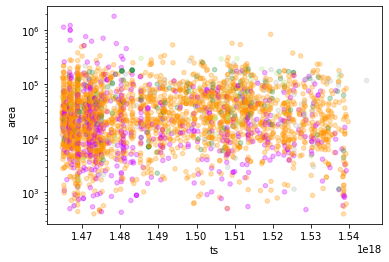

In [183]:
dfs['EU'][['ts','area','cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']].plot.scatter(x='ts',y='area', color=dfs['EU']['colors'].values,logy=True, alpha=0.3)

In [55]:
pd.to_datetime(dfs['EU']['ts'])

15250   2016-06-02
13747   2016-06-02
13184   2016-06-02
29497   2016-06-02
14147   2016-06-02
           ...    
60934   2018-10-11
26974   2018-10-11
10485   2018-10-12
29780   2018-10-17
67017   2018-12-12
Name: ts, Length: 3222, dtype: datetime64[ns]

In [181]:
dfs['IN'][['cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']].clip(0)

,cropland,forest,grasslands,developed,other,wetlands
15352,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
15682,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
62389,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
68160,0.830083,0.169917,0.000000,0.000000,0.000000e+00,0.0
16420,0.847032,0.152968,0.000000,0.000000,0.000000e+00,0.0
...,...,...,...,...,...,...
29076,0.270506,0.001346,0.711496,0.016652,1.329219e-16,0.0
29071,0.274774,0.001338,0.707333,0.016555,1.321441e-16,0.0
29073,0.278993,0.001330,0.703218,0.016458,1.313754e-16,0.0
62443,0.349758,0.001200,0.634200,0.014843,1.184814e-16,0.0


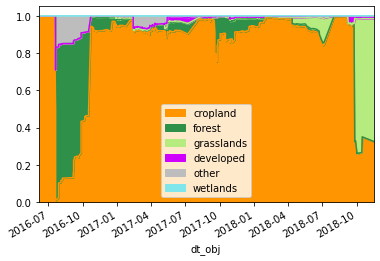

In [182]:
dfs['IN'].set_index('dt_obj')[['cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']].clip(0).plot.area(color=[colors_dict[kk] for kk in ['cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']])

In [211]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [216]:
ax = fig.add_axes([0,0,0.5,0.5])

In [219]:
ax.plot(1,1)
plt.show()

In [61]:
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/too

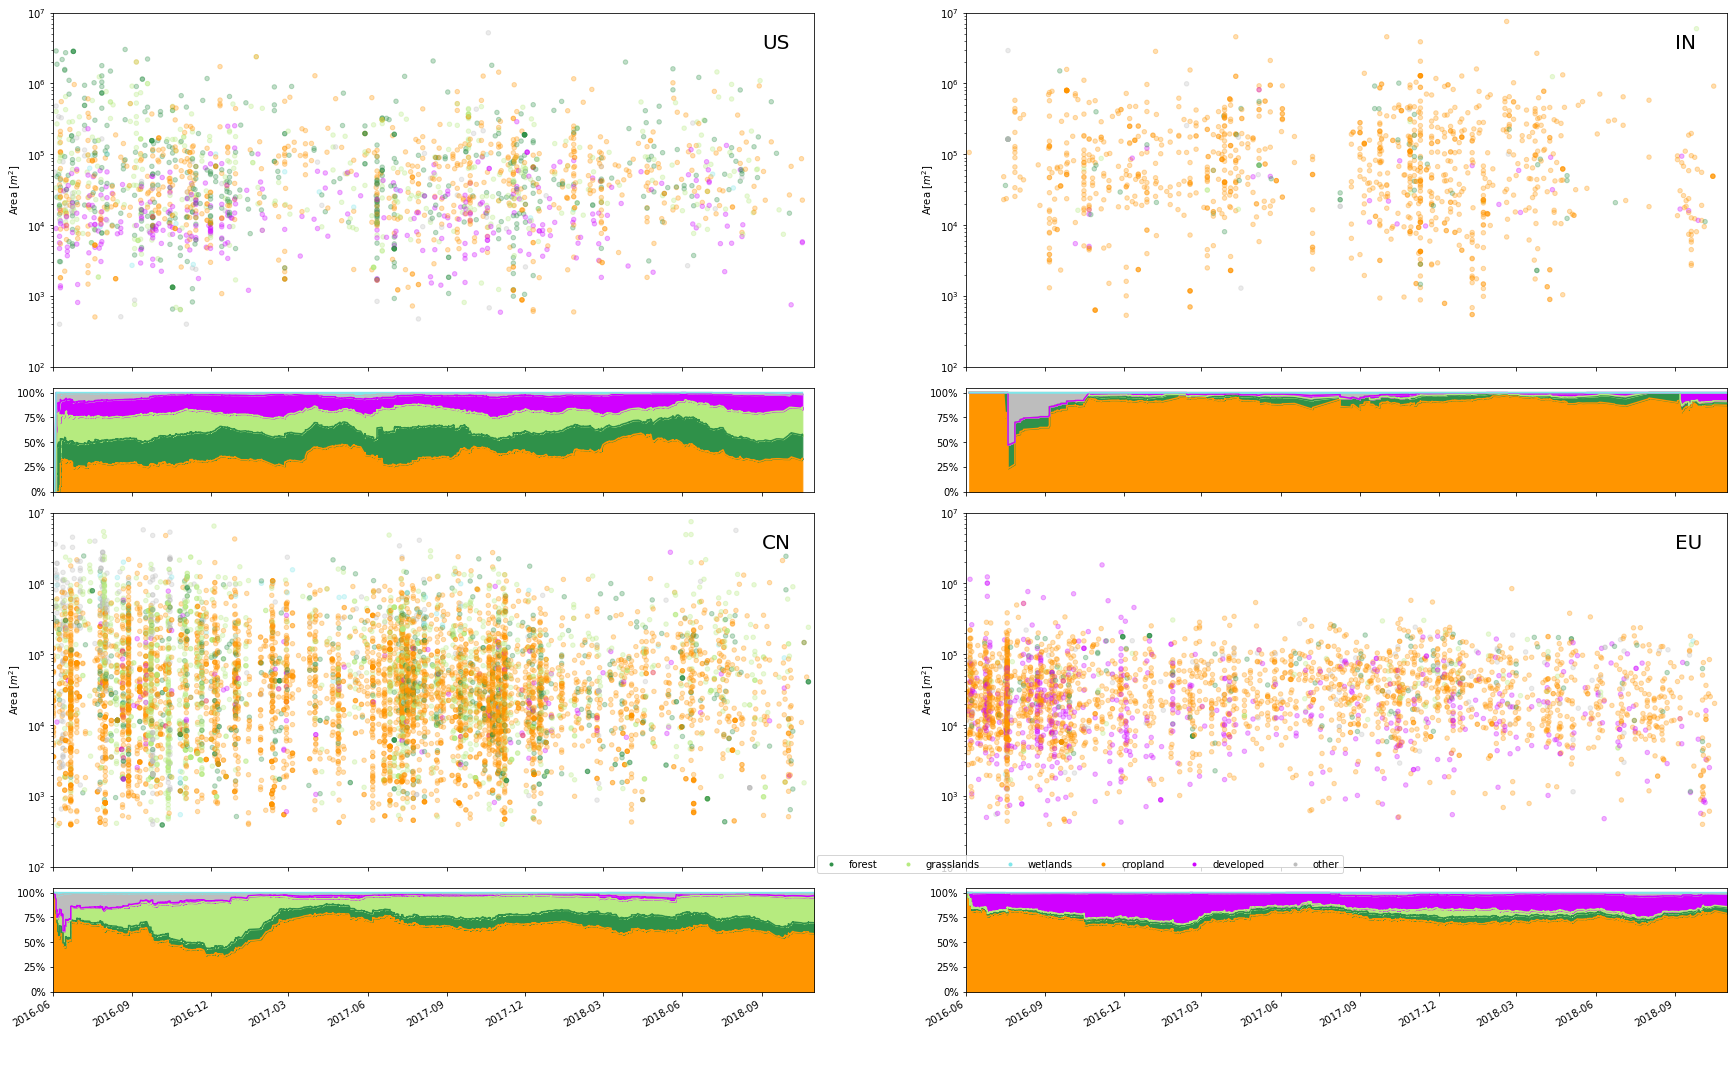

In [62]:
fig = plt.figure(figsize=(30,20))

gs = GridSpec(8, 2, figure=fig)

axs = {kk:{} for kk in ['US','CN','IN','EU']}

for ii_k, kk in enumerate(['US','CN','IN','EU']):
    axs[kk]['scatter'] = fig.add_subplot(gs[(ii_k%2)*4:(ii_k%2)*4+3,ii_k//2])
    axs[kk]['area'] = fig.add_subplot(gs[(ii_k%2)*4+3,ii_k//2])


for kk in ['US','CN','IN','EU']:
    dfs[kk][['ts','area','cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']].plot.scatter(ax=axs[kk]['scatter'],x='ts',y='area', color=dfs[kk]['colors'].values,logy=True, alpha=0.3)
    dfs[kk].set_index('dt_obj')[['cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']].plot.area(ax=axs[kk]['area'], color=[colors_dict[kk] for kk in ['cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']],legend=False)

    
for ii_k, kk in enumerate(['US','CN','IN','EU']):
    axs[kk]['scatter'].set_xticks([np.datetime64(dt.strptime('2016-06-01','%Y-%m-%d') + relativedelta(months=mm)).astype(np.int64)*1000 for mm in range(0,33,3)])
    axs[kk]['area'].set_xticks([(dt.strptime('2016-06-01','%Y-%m-%d') + relativedelta(months=mm)) for mm in range(0,33,3)])
    
    axs[kk]['scatter'].set_xticklabels(['' for _ in axs[kk]['scatter'].get_xticks()])
    if kk in ['US','IN']:
        axs[kk]['area'].set_xticklabels(['' for mm in range(0,33,3)])
    else:
        axs[kk]['area'].set_xticklabels([str((dt.strptime('2016-06-01','%Y-%m-%d') + relativedelta(months=mm)))[0:7] for mm in range(0,33,3)])
    #print ( [pd.Timestamp(tt*1000*10) for tt in axs[kk]['area'].get_xticks()])
    #axs[kk]['area'].set_xticklabels([ axs[kk]['area'].get_xticks()])
    

    axs[kk]['scatter'].set_ylabel('Area [$m^2$]')
    axs[kk]['area'].set_xlabel('')
    axs[kk]['scatter'].set_xlabel('')
    
    axs[kk]['area'].set_xlim(['2016-06-01','2018-10-31'])
    axs[kk]['scatter'].set_xlim([np.datetime64(dt.strptime('2016-06-01','%Y-%m-%d')).astype(np.int64)*1000, np.datetime64(dt.strptime('2018-10-31','%Y-%m-%d')).astype(np.int64)*1000])
    axs[kk]['scatter'].set_ylim([10**2, 10**7])
    axs[kk]['area'].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axs[kk]['scatter'].text(np.datetime64(dt.strptime('2018-09-01','%Y-%m-%d')).astype(np.int64)*1000,10**6.5,kk, fontsize=20)
    
    #axs[kk]['area'] = fig.add_subplot(gs[(ii_k%2)*4+3,ii_k//2])
    
    
    #print ([ts for ts in ax.get_xticks()])
    #axs[kk]['scatter'].set_xticklabels([dt.fromtimestamp(ts).strftime('%Y-%m') for ts in ax.get_xticks()])
    
custom_lines = []
for kk,vv in colors_dict.items():
    custom_lines.append(Line2D([0],[0],color=vv,marker='.',linestyle=None, lw=0))


lgd = fig.legend(custom_lines, colors_dict.keys(), ncol=6, bbox_to_anchor=(0.5, 0.15), loc='center',fancybox=True)

plt.savefig('./land_cover.png', bbox_extra_artists=(lgd,))
plt.show()

### With Dist

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/too

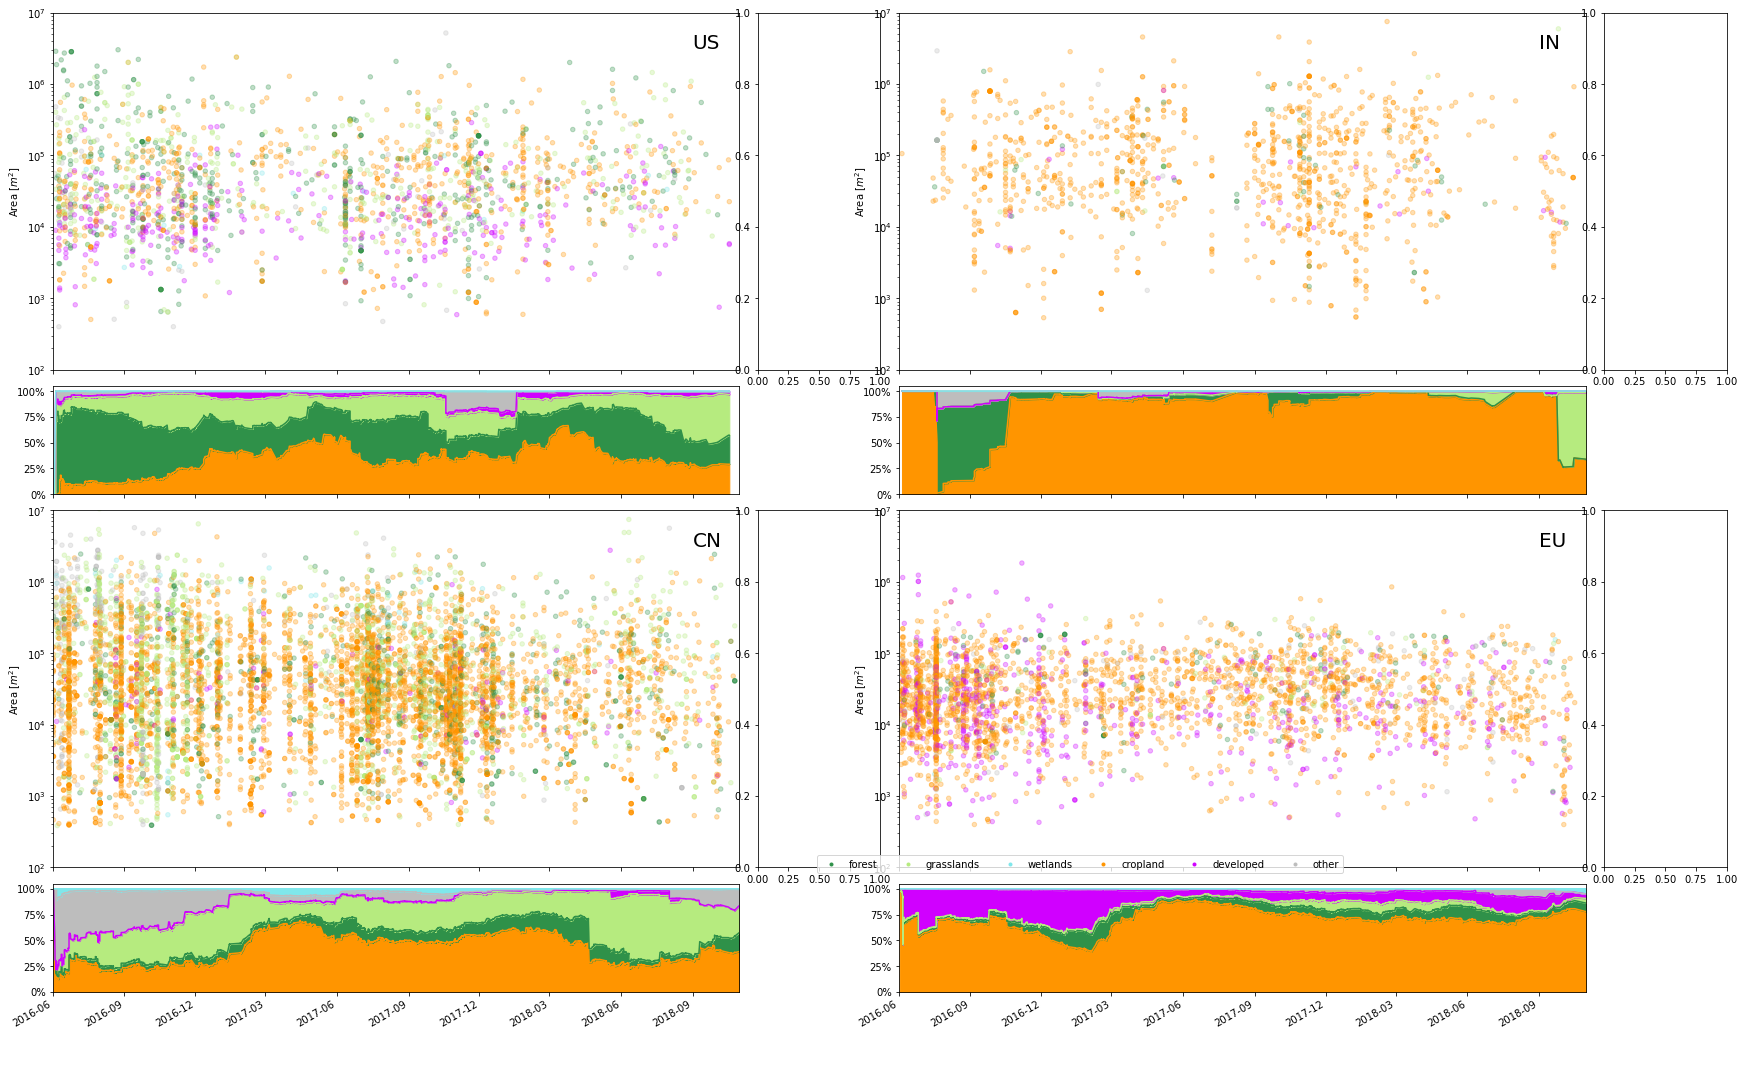

In [187]:
fig = plt.figure(figsize=(30,20))

gs = GridSpec(8, 12, figure=fig, wspace=0.15, hspace=0.15)

axs = {kk:{} for kk in ['US','CN','IN','EU']}

for ii_k, kk in enumerate(['US','CN','IN','EU']):
    axs[kk]['scatter'] = fig.add_subplot(gs[(ii_k%2)*4:(ii_k%2)*4+3,(ii_k//2)*6:(ii_k//2)*6+5])
    axs[kk]['area'] = fig.add_subplot(gs[(ii_k%2)*4+3,(ii_k//2)*6:(ii_k//2)*6+5])
    axs[kk]['dist'] = fig.add_subplot(gs[(ii_k%2)*4:(ii_k%2)*4+3,  (ii_k//2)*6+5 ])


for kk in ['US','CN','IN','EU']:
    dfs[kk][['ts','area','cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']].plot.scatter(ax=axs[kk]['scatter'],x='ts',y='area', color=dfs[kk]['colors'].values,logy=True, alpha=0.3)
    dfs[kk].set_index('dt_obj')[['cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']].clip(0).plot.area(ax=axs[kk]['area'], color=[colors_dict[kk] for kk in ['cropland', 'forest', 'grasslands', 'developed', 'other', 'wetlands']],legend=False)

    
for ii_k, kk in enumerate(['US','CN','IN','EU']):
    axs[kk]['scatter'].set_xticks([np.datetime64(dt.strptime('2016-06-01','%Y-%m-%d') + relativedelta(months=mm)).astype(np.int64)*1000 for mm in range(0,33,3)])
    axs[kk]['area'].set_xticks([(dt.strptime('2016-06-01','%Y-%m-%d') + relativedelta(months=mm)) for mm in range(0,33,3)])
    
    axs[kk]['scatter'].set_xticklabels(['' for _ in axs[kk]['scatter'].get_xticks()])
    if kk in ['US','IN']:
        axs[kk]['area'].set_xticklabels(['' for mm in range(0,33,3)])
    else:
        axs[kk]['area'].set_xticklabels([str((dt.strptime('2016-06-01','%Y-%m-%d') + relativedelta(months=mm)))[0:7] for mm in range(0,33,3)])
    #print ( [pd.Timestamp(tt*1000*10) for tt in axs[kk]['area'].get_xticks()])
    #axs[kk]['area'].set_xticklabels([ axs[kk]['area'].get_xticks()])
    

    axs[kk]['scatter'].set_ylabel('Area [$m^2$]')
    axs[kk]['area'].set_xlabel('')
    axs[kk]['scatter'].set_xlabel('')
    
    axs[kk]['area'].set_xlim(['2016-06-01','2018-10-31'])
    axs[kk]['scatter'].set_xlim([np.datetime64(dt.strptime('2016-06-01','%Y-%m-%d')).astype(np.int64)*1000, np.datetime64(dt.strptime('2018-10-31','%Y-%m-%d')).astype(np.int64)*1000])
    axs[kk]['scatter'].set_ylim([10**2, 10**7])
    axs[kk]['area'].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axs[kk]['scatter'].text(np.datetime64(dt.strptime('2018-09-01','%Y-%m-%d')).astype(np.int64)*1000,10**6.5,kk, fontsize=20)
    
    #axs[kk]['area'] = fig.add_subplot(gs[(ii_k%2)*4+3,ii_k//2])
    
    
    #print ([ts for ts in ax.get_xticks()])
    #axs[kk]['scatter'].set_xticklabels([dt.fromtimestamp(ts).strftime('%Y-%m') for ts in ax.get_xticks()])
    
custom_lines = []
for kk,vv in colors_dict.items():
    custom_lines.append(Line2D([0],[0],color=vv,marker='.',linestyle=None, lw=0))


lgd = fig.legend(custom_lines, colors_dict.keys(), ncol=6, bbox_to_anchor=(0.5, 0.15), loc='center',fancybox=True)

plt.savefig('./land_cover.png', bbox_extra_artists=(lgd,))
plt.show()

In [188]:
dfs['US']

,area,iso-3166-1,dt_obj,land_cover_vis,cropland,forest,grasslands,developed,other,wetlands,dt_obj_rolling,cropland_rolling,forestshrub_rolling,grassy_rolling,human_rolling,other_rolling,wetlands_rolling,rolling_sum,ts,colors
68669,5.610070e+04,US,2016-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000e+00,1464912000000000000,#bdbdbd
67571,8.946927e+03,US,2016-06-05,human,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,2016-06-05,0.000000e+00,0.000000e+00,0.000000e+00,8946.926657,0.000000e+00,0.00000,8.946927e+03,1465084800000000000,#d000ff
28949,3.354625e+04,US,2016-06-05,grassy,0.000000,0.000000,0.789450,0.210550,0.000000e+00,0.000000,2016-06-05,0.000000e+00,0.000000e+00,3.354625e+04,8946.926657,0.000000e+00,0.00000,4.249317e+04,1465084800000000000,#b6eb7f
28911,4.022441e+05,US,2016-06-05,grassy,0.000000,0.000000,0.979883,0.020117,0.000000e+00,0.000000,2016-06-05,0.000000e+00,0.000000e+00,4.357903e+05,8946.926657,0.000000e+00,0.00000,4.447372e+05,1465084800000000000,#b6eb7f
25397,2.874015e+06,US,2016-06-05,forestshrub,0.000000,0.865993,0.131311,0.002696,0.000000e+00,0.000000,2016-06-05,0.000000e+00,2.874015e+06,4.357903e+05,8946.926657,0.000000e+00,0.00000,3.318752e+06,1465084800000000000,#2f9149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62905,6.751817e+04,US,2018-10-05,cropland,0.293845,0.219521,0.462914,0.020907,1.591171e-17,0.002813,2018-10-05,3.493535e+06,2.609888e+06,5.503595e+06,248566.580161,1.891749e-10,33449.47292,1.188903e+07,1538697600000000000,#ff9500
62786,8.660064e+04,US,2018-10-17,cropland,0.289430,0.281974,0.396443,0.028264,2.199577e-17,0.003889,2018-10-17,2.489247e+06,2.425116e+06,3.409609e+06,243088.959974,1.891749e-10,33449.47292,8.600511e+06,1539734400000000000,#ff9500
62615,2.252351e+04,US,2018-10-18,cropland,0.291286,0.281237,0.395407,0.028191,2.193832e-17,0.003879,2018-10-18,2.511770e+06,2.425116e+06,3.409609e+06,243088.959974,1.891749e-10,33449.47292,8.623034e+06,1539820800000000000,#ff9500
62654,5.818743e+03,US,2018-10-18,human,0.291090,0.281047,0.395141,0.028846,2.192353e-17,0.003876,2018-10-18,2.511770e+06,2.425116e+06,3.409609e+06,248907.702491,1.891749e-10,33449.47292,8.628853e+06,1539820800000000000,#d000ff


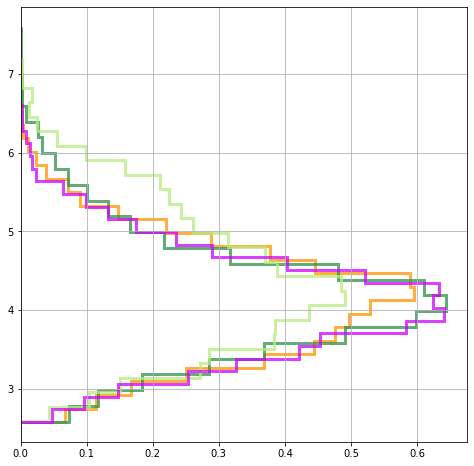

In [157]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for col in ['cropland','forestshrub','grassy','human']:
    np.log10(df[df[col]==1].area).hist(ax=ax, bins=25, alpha=0.75, edgecolor=colors_base[col],histtype='step', linewidth=3,density=True, orientation='horizontal', fill=False)



In [ ]:
fig, axs = plt.subplots(2,2,figsize=(20,20))
print (axs)
print (axs[0,0])

for ii_k, kk in enumerate(['US','CN','IN','EU']):

    print (kk)
    dfs[kk].drop(columns=['sum']).plot(ax=axs[ii_k%2,ii_k//2])
    axs[ii_k%2,ii_k//2].set_title(kk)
    #axs[ii_k%2,ii_k//2].set_xticks_labels([dt_range])
    axs[ii_k%2,ii_k//2].set_xlabel('')
    axs[ii_k%2,ii_k//2].set_xticklabels([tt[0:7] for tt in ['2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31',
               '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31',
               '2018-06-30', '2018-09-30']])
    axs[ii_k%2,ii_k//2].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    

fig.savefig('land_cover_summary.png')
plt.show()

#### time binned

In [275]:
us_df = df.loc[df['iso-3166-1']=='US',:].groupby(pd.cut(df.loc[df['iso-3166-1']=='US','dt_obj'], bins=dt_range)).sum()

In [276]:
cn_df = df.loc[df['iso-3166-1']=='CN',:].groupby(pd.cut(df.loc[df['iso-3166-1']=='CN','dt_obj'], bins=dt_range)).sum()

In [277]:
in_df = df.loc[df['iso-3166-1']=='IN',:].groupby(pd.cut(df.loc[df['iso-3166-1']=='IN','dt_obj'], bins=dt_range)).sum()

In [278]:
eu_df = df.loc[df['iso-3166-1'].isin(corine_countries),:].groupby(pd.cut(df.loc[df['iso-3166-1'].isin(corine_countries),'dt_obj'], bins=dt_range)).sum()

In [283]:
dfs = {
    'US':us_df,
    'CN':cn_df,
    'IN':in_df,
    'EU':eu_df
}

In [289]:
for kk in ['US','CN','IN','EU']:
    dfs[kk]['sum'] = dfs[kk].sum(axis=1)

In [291]:
for kk in ['US','CN','IN','EU']:
    for cc in ['cropland', 'forestshrub', 'grassy', 'human', 'other', 'wetlands']:
        dfs[kk][cc] = dfs[kk][cc]/dfs[kk]['sum']

In [309]:
import matplotlib.ticker as mtick

In [311]:
dt_range

DatetimeIndex(['2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31',
               '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31',
               '2018-06-30', '2018-09-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='3M')

In [316]:
for kk in ['US','CN','IN','EU']:
    
    dfs[kk] = dfs[kk].rename(columns={'forestshrub':'forest', 'grassy':'grasslands', 'human':'developed'})

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7efb52d3f4d0>
AxesSubplot(0.125,0.536818;0.352273x0.343182)
US
CN
IN
EU


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

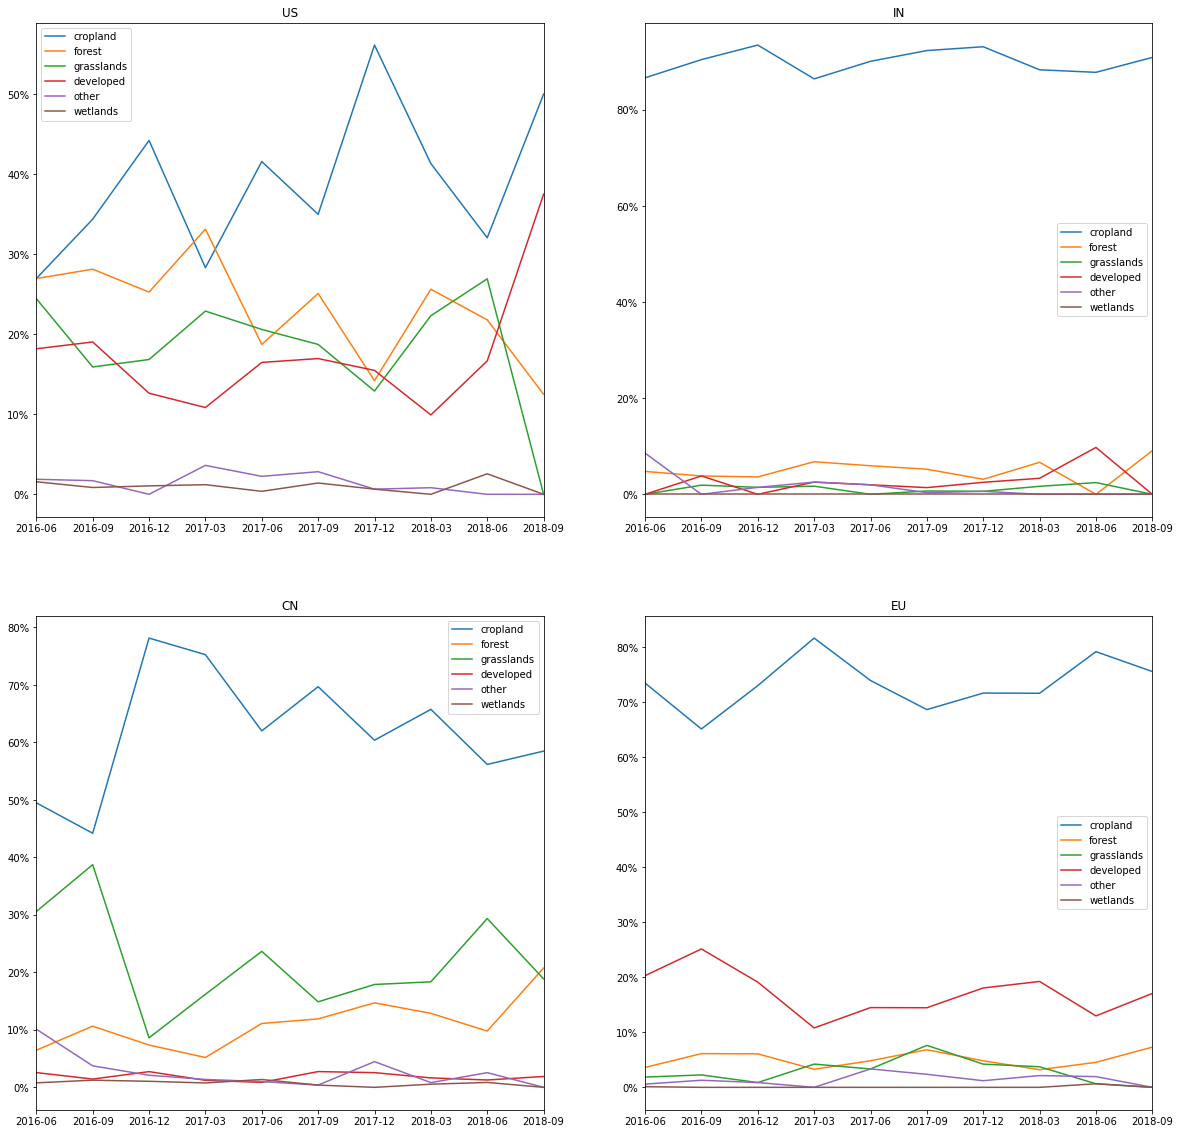

In [317]:
fig, axs = plt.subplots(2,2,figsize=(20,20))
print (axs)
print (axs[0,0])

for ii_k, kk in enumerate(['US','CN','IN','EU']):

    print (kk)
    dfs[kk].drop(columns=['sum']).plot(ax=axs[ii_k%2,ii_k//2])
    axs[ii_k%2,ii_k//2].set_title(kk)
    #axs[ii_k%2,ii_k//2].set_xticks_labels([dt_range])
    axs[ii_k%2,ii_k//2].set_xlabel('')
    axs[ii_k%2,ii_k//2].set_xticklabels([tt[0:7] for tt in ['2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31',
               '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31',
               '2018-06-30', '2018-09-30']])
    axs[ii_k%2,ii_k//2].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    

fig.savefig('land_cover_summary.png')
plt.show()

In [292]:
dfs

{'US':                           cropland  forestshrub    grassy     human     other  \
 dt_obj                                                                          
 (2016-06-30, 2016-09-30]  0.269592     0.269592  0.244514  0.181818  0.018809   
 (2016-09-30, 2016-12-31]  0.343750     0.281250  0.159091  0.190341  0.017045   
 (2016-12-31, 2017-03-31]  0.442105     0.252632  0.168421  0.126316  0.000000   
 (2017-03-31, 2017-06-30]  0.283133     0.331325  0.228916  0.108434  0.036145   
 (2017-06-30, 2017-09-30]  0.415730     0.187266  0.205993  0.164794  0.022472   
 (2017-09-30, 2017-12-31]  0.349823     0.250883  0.187279  0.169611  0.028269   
 (2017-12-31, 2018-03-31]  0.561290     0.141935  0.129032  0.154839  0.006452   
 (2018-03-31, 2018-06-30]  0.413223     0.256198  0.223140  0.099174  0.008264   
 (2018-06-30, 2018-09-30]  0.320513     0.217949  0.269231  0.166667  0.000000   
 (2018-09-30, 2018-12-31]  0.500000     0.125000  0.000000  0.375000  0.000000   
 
        

In [290]:
eu_df.columns

Index(['cropland', 'forestshrub', 'grassy', 'human', 'other', 'wetlands',
       'sum'],
      dtype='object')

In [234]:
pd.get_dummies(df['land_cover_vis'])

,cropland,forestshrub,grassy,human,other,wetlands
7,0,0,0,0,1,0
16,0,0,0,1,0,0
19,0,0,0,1,0,0
29,0,0,1,0,0,0
31,0,0,1,0,0,0
...,...,...,...,...,...,...
68782,1,0,0,0,0,0
68783,0,0,0,0,1,0
68791,0,0,1,0,0,0
68793,1,0,0,0,0,0


In [205]:
df.columns

Index(['area', 'confidence', 'install_date', 'install_date_ints', 'SPOT_ids_0',
       'S2_ids_0', 'iso-3166-1', 'iso-3166-2', 'land_cover_CORINE_2006',
       'land_cover_CORINE_2012', 'land_cover_CORINE_2018',
       'land_cover_MODIS_2006', 'land_cover_MODIS_2007',
       'land_cover_MODIS_2008', 'land_cover_MODIS_2009',
       'land_cover_MODIS_2010', 'land_cover_MODIS_2011',
       'land_cover_MODIS_2012', 'land_cover_MODIS_2013',
       'land_cover_MODIS_2014', 'land_cover_MODIS_2015',
       'land_cover_MODIS_2016', 'land_cover_MODIS_2017',
       'land_cover_MODIS_2018', 'SPOT_ids_1', 'SPOT_ids_2', 'S2_ids_1',
       'SPOT_ids_3', 'SPOT_ids_4', 'SPOT_ids_5', 'SPOT_ids_6', 'SPOT_ids_7',
       'SPOT_ids_8', 'land_cover_CDL_2006', 'land_cover_CDL_2007',
       'land_cover_CDL_2008', 'land_cover_CDL_2009', 'land_cover_CDL_2010',
       'land_cover_CDL_2011', 'land_cover_CDL_2012', 'land_cover_CDL_2013',
       'land_cover_CDL_2014', 'land_cover_CDL_2015', 'land_cover_CDL_2016',
  

In [163]:
df['install_date']=df['install_date'].str.split(',')[0]

KeyError: 0

In [115]:
for kk, vv in labels.items():
    print (kk)
    for kk2, vv2 in vv.items():
        print (kk2,vv2)

CORINE
1 {'code': '111', 'description': 'Continuous urban fabric'}
2 {'code': '112', 'description': 'Discontinuous urban fabric'}
3 {'code': '121', 'description': 'Industrial or commercial units'}
4 {'code': '122', 'description': 'Road and rail networks and associated land'}
5 {'code': '123', 'description': 'Port areas'}
6 {'code': '124', 'description': 'Airports'}
7 {'code': '131', 'description': 'Mineral extraction sites'}
8 {'code': '132', 'description': 'Dump sites'}
9 {'code': '133', 'description': 'Construction sites'}
10 {'code': '141', 'description': 'Green urban areas'}
11 {'code': '142', 'description': 'Sport and leisure facilities'}
12 {'code': '211', 'description': 'Non-irrigated arable land'}
13 {'code': '212', 'description': 'Permanently irrigated land'}
14 {'code': '213', 'description': 'Rice fields'}
15 {'code': '221', 'description': 'Vineyards'}
16 {'code': '222', 'description': 'Fruit trees and berry plantations'}
17 {'code': '223', 'description': 'Olive groves'}
18 {